In [1]:
# settings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mpl_dates 
import matplotlib.pyplot as plt
import mplfinance as mpf
import yfinance as yf
import pandas as pd
import numpy as np 
import datetime

#stocks = ["META","AMZN"]
stocks = ["META", "AMZN", "AAPL", "NFLX", "GOOG"]
start_date = "2020-01-01"

first = datetime.date.today().replace(day=1)
last_month = first - datetime.timedelta(days=1)
start_date_ohcl = datetime.datetime.combine(last_month.replace(day=1), datetime.datetime.min.time())

ran_seed=20240407

# Download Stock data from yfinance
Selected stocks: Meta, Amazon, Apple, Netflix, Google

Plot time series of stocks since start_date

[*********************100%%**********************]  5 of 5 completed


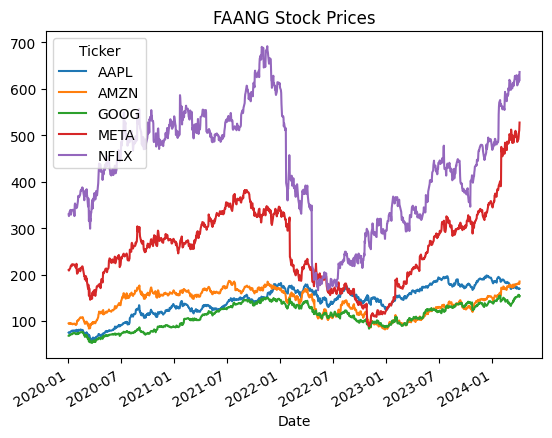

Price        Adj Close                                                  \
Ticker            AAPL        AMZN        GOOG        META        NFLX   
Date                                                                     
2024-04-05  169.580002  185.070007  153.940002  527.340027  636.179993   
2024-04-04  168.820007  180.000000  151.940002  510.920013  617.140015   
2024-04-03  169.649994  182.410004  156.369995  506.739990  630.080017   
2024-04-02  168.839996  180.690002  155.869995  497.369995  614.210022   
2024-04-01  170.029999  180.970001  156.500000  491.350006  614.309998   

Price            Close                                                  ...  \
Ticker            AAPL        AMZN        GOOG        META        NFLX  ...   
Date                                                                    ...   
2024-04-05  169.580002  185.070007  153.940002  527.340027  636.179993  ...   
2024-04-04  168.820007  180.000000  151.940002  510.920013  617.140015  ...   
2024-04-03  

In [2]:
data = yf.download(stocks, start=start_date)

data['Close'].plot()
plt.title("FAANG Stock Prices")
plt.show()

print(data.sort_values('Date', ascending=False).head())

# Adjust format of data set and create new data set for closing prices 

In [3]:
data_close = data['Close'].reset_index()
data = data.stack(future_stack=True).reset_index().sort_values(['Date','Ticker'])
data.index = pd.DatetimeIndex(data['Date'])
data = data.rename(columns={"Date": "Datum"})

# Calculate daily returns and create plots

Ticker       Date       AAPL       AMZN       GOOG        META        NFLX  \
0      2020-01-02  75.087502  94.900497  68.368500  209.779999  329.809998   
1      2020-01-03  74.357498  93.748497  68.032997  208.669998  325.899994   
2      2020-01-06  74.949997  95.143997  69.710503  212.600006  335.829987   
3      2020-01-07  74.597504  95.343002  69.667000  213.059998  330.750000   
4      2020-01-08  75.797501  94.598503  70.216003  215.220001  339.260010   

Ticker    META_r    AMZN_r    AAPL_r    NFLX_r    GOOG_r  
0            NaN       NaN       NaN       NaN       NaN  
1      -0.529126 -1.213903 -0.972204 -1.185532 -0.490727  
2       1.883360  1.488557  0.796825  3.046945  2.465723  
3       0.216365  0.209162 -0.470305 -1.512666 -0.062405  
4       1.013801 -0.780864  1.608629  2.572943  0.788040  


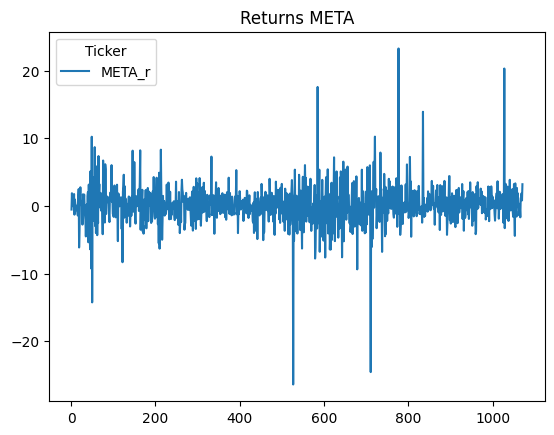

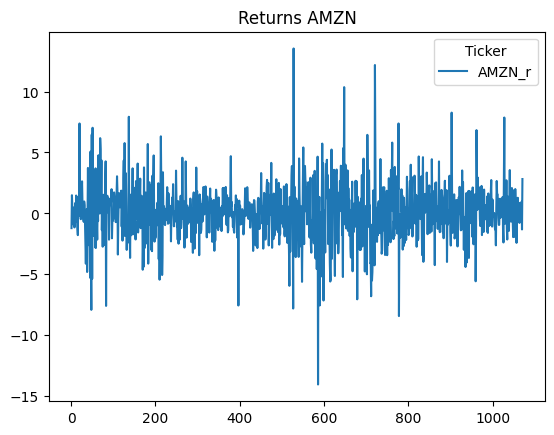

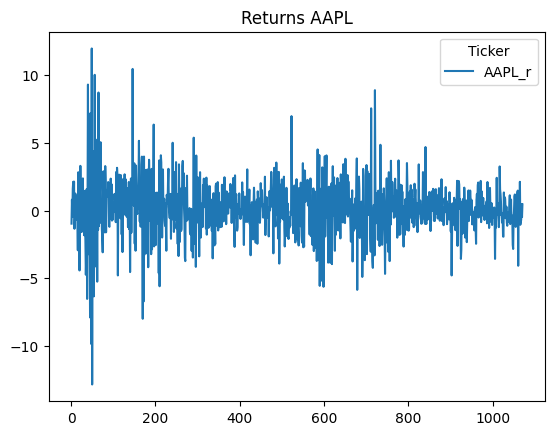

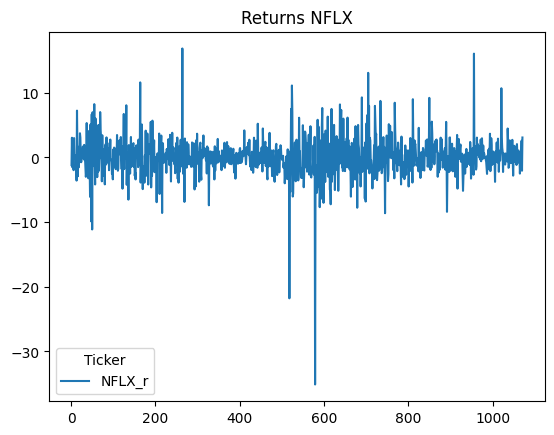

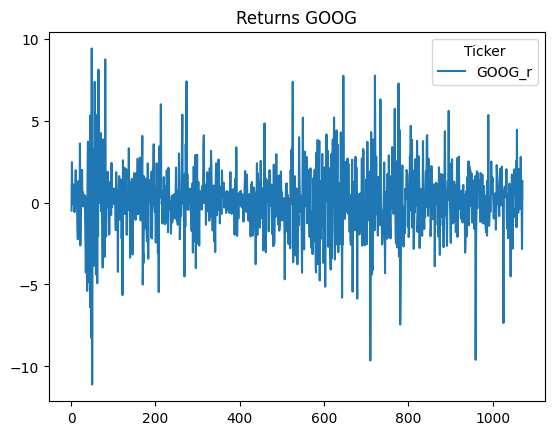

In [4]:
def calc_returns(df,stock):
    df[str(stock) + "_r"] = df[stock].pct_change() * 100

for s in stocks:
    calc_returns(data_close, s)

print(data_close.head())

for s in stocks:
    data_close[[str(s) + "_r"]].plot()
    plt.title("Returns " + str(s))
    plt.show()

# Plot Candlestick charts

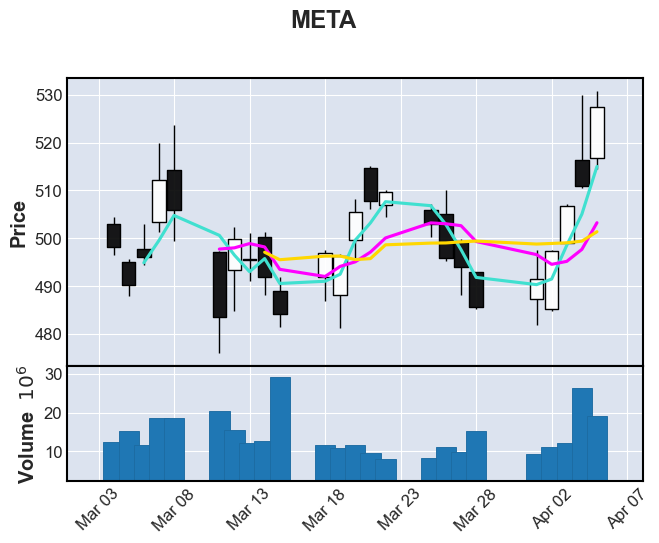

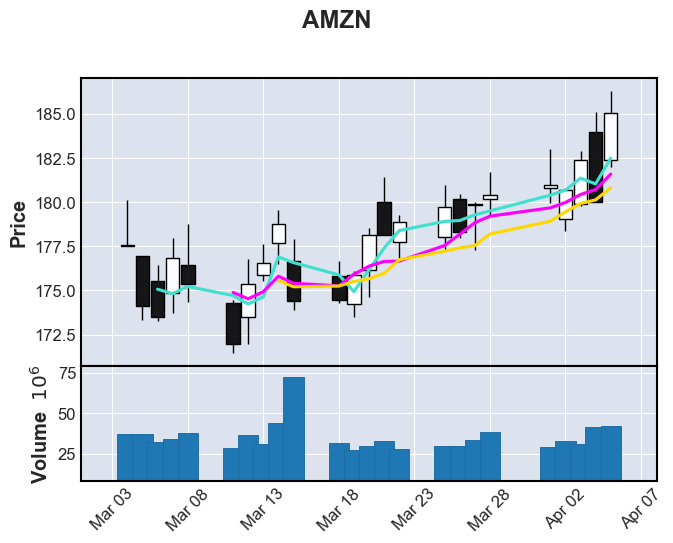

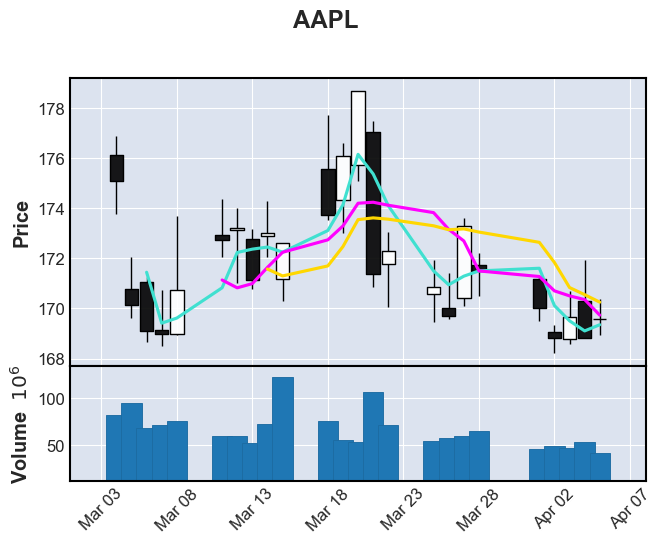

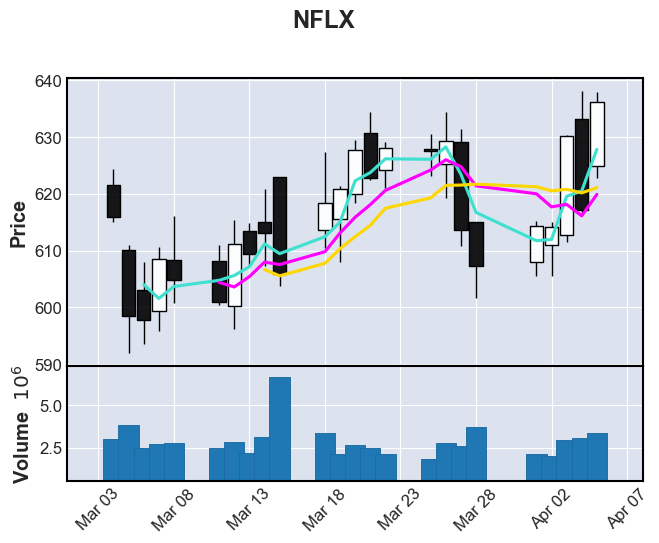

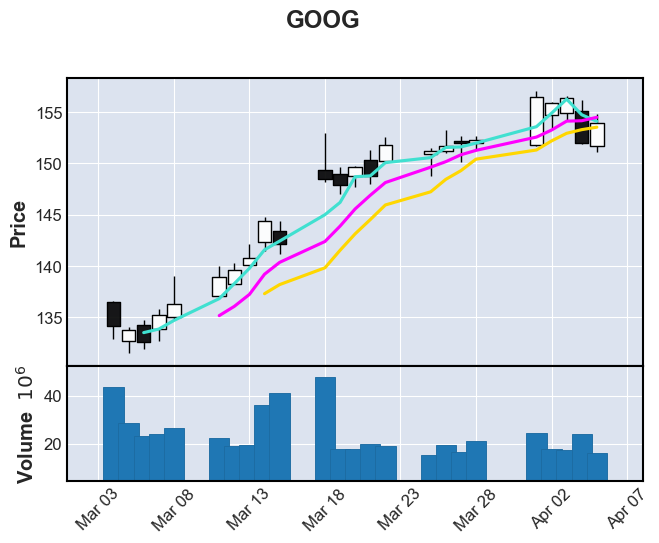

In [5]:
for s in stocks:
    mpf.plot(data[(data.Ticker == str(s)) & (data.Datum > start_date_ohcl)],type='candle',mav=(3,6,9),volume=True,show_nontrading=True, title=str(s))

# Attempt of LSTM model to forecast stock trends
For now only for Apple stocks and using Open- and High-Prices

Following https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233

In [6]:
data_total = data[(data.Ticker == "AAPL")].reset_index()
data_total = data_total[["Open","High"]]

data_train, data_test = train_test_split(data_total, test_size=0.3, shuffle = False)

sc = MinMaxScaler(feature_range=(0,1))
data_train[["Open","High"]] = sc.fit_transform(data_train[["Open","High"]])
data_test[["Open","High"]] = sc.transform(data_test[["Open","High"]])

In [7]:
len_train = len(data_train)
len_test = len(data_test)
len_total = len(data_total)

X_train = []
y_train = []

for i in range(60, len_train):
    X_train.append(data_train.iloc[i-60:i, 0])
    y_train.append(data_train.iloc[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Development of LSTM Model using Keras

In [8]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

2024-04-07 15:12:15.190913: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=50,batch_size=32)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - loss: 0.1743
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - loss: 0.0177
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - loss: 0.0107
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - loss: 0.0085
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 0.0090
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - loss: 0.0081
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - loss: 0.0084
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - loss: 0.0092
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - loss: 0.0081
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 340ms/step - loss: 0.0082
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step - loss: 0.0069
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - loss: 0.0080
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - loss: 0.0066
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - loss: 0.0065
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - 

# Application of model on Test sample and plot

In [13]:
X_test = []
data_total = pd.concat((data_train, data_test), axis = 0)

for i in range(len_total - len_test, len(data_total)):
    X_test.append(data_total.iloc[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price_raw = model.predict(X_test)
predicted_stock_price = pd.DataFrame(np.zeros((len(predicted_stock_price_raw), len(data_test.columns))), columns=data_test.columns)
predicted_stock_price['Open'] = predicted_stock_price_raw

predicted_stock_price = pd.DataFrame(sc.inverse_transform(predicted_stock_price),columns=['Open','High']).drop(columns={"High"})
real_stock_price = pd.DataFrame(sc.inverse_transform(data_test),columns=['Open','High']).drop(columns={"High"})

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step


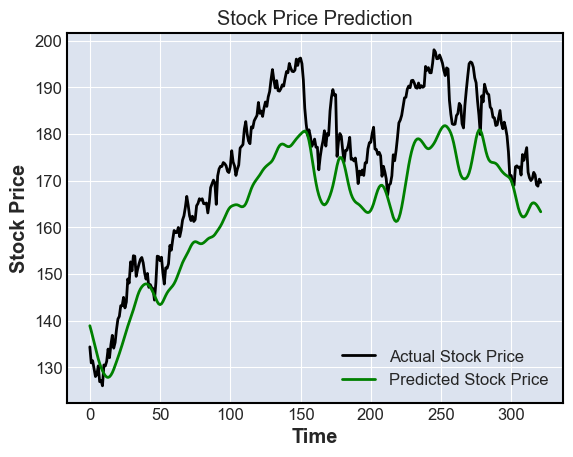

In [14]:
plt.plot(real_stock_price, color = 'black', label = 'Actual Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()